# Homework 5: Failure Transition Heat-Map

This notebook walks through analyzing where an agent fails in its pipeline.

**What you'll learn:**
- How to build a transition matrix from failure data
- How to visualize failure patterns with a heatmap
- How to interpret failure patterns to identify system issues

Video walkthrough: https://youtu.be/z1oISsDUKLA

**Bonus**: [Using AI Assisted Coding to Tackle Homework Problems](https://link.courses.maven.com/c/eJw80M2upCAQBeCngZ0Gil8XLGbja5gCymkTbAyoyX37id2Tu6rUl7OoOqm-ajuXLQeQk554qlfr9OxST8rxHHQWMhpOQTrrrFIgNacdt7Kkgr2H2CrmhP38r-fPQYHerZZCmdP7Xr5-XVsOR6t5hKSzIXKDB2MHnQwNHiQMWhIJQ-C9Q_4K3mmbY1zRC_LZw-Scw9XHKCe_Kot8CyDACimMdFIpNRpjwGaX_JogSeuZFt9_-rjjTe8x1Z1vfVlb3ZePhBlLJ17C6zyPztQfBjOD-TfNYD6wFXwnGgrGzmCmG8szQYAZFIO5_5SC8Xpsr_kq9El5J4ziLWwdMY1rwfPFtPj7VPE54w7wLwAA__8a93gB)

![AI Assisted Coding Walkthrough Location](../imgs/AIHwWalkthrough.png)

In [1]:
import json
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Look at Your Data First

Before writing any code, **look at your data**. Each trace represents a conversation where the agent failed at some point.

> 💡 **What's a transition heatmap?** It shows where things were working (rows) and where they broke (columns). Hot spots reveal which transitions are most fragile.

The key fields are:
- `last_success_state` - the last pipeline step that succeeded
- `first_failure_state` - the first step that failed

### Use the HTML Viewer

Open `reference_files/trace_viewer.html` in your browser and upload the JSONL file. This lets you:
- Navigate between traces with arrow keys
- See the conversation messages and failure states
- Understand the data structure before coding

**Pro tip**: You can vibe-code your own viewer. Try this prompt:

> "Make a self-contained HTML file to view JSONL files. It should let me upload a file, navigate between records, and display all fields nicely."

This is a useful skill for quickly exploring any dataset.

In [2]:
BASE_PATH = Path('reference_files')

# Load traces (JSONL format)
traces = []
with open(BASE_PATH / 'labeled_traces.jsonl') as f:
    for line in f:
        if line.strip():
            traces.append(json.loads(line))

print(f"Loaded {len(traces)} traces")
print(f"Example trace keys: {list(traces[0].keys())}")

Loaded 96 traces
Example trace keys: ['conversation_id', 'messages', 'last_success_state', 'first_failure_state']


In [3]:
# Look at one trace
trace = traces[0]
print(f"Conversation ID: {trace['conversation_id']}")
print(f"Last success: {trace['last_success_state']}")
print(f"First failure: {trace['first_failure_state']}")
print(f"\nMessages ({len(trace['messages'])} total):")
for msg in trace['messages'][:3]:
    print(f"  [{msg['role']}] {msg['content'][:80]}...")

Conversation ID: 1373de99-f107-48da-b272-9e47c9b935dd
Last success: ParseRequest
First failure: GetCustomerProfile

Messages (8 total):
  [user] What vegetarian high-protein meal can I cook tonight?...
  [assistant] Let me help you find a delicious vegetarian meal that's high in protein for toni...
  [assistant] TOOL_CALL[GetCustomerProfile] Unable to access user profile at this time. Prefer...


## 2. Understand the Pipeline States

The agent processes requests through a series of steps. Each step can succeed or fail.

> 💡 **Why does this matter?** If most failures happen at "GetRecipes," you know to focus on your recipe database or search logic. If failures cluster at "GenCustomerArgs," the LLM is struggling to format its tool calls correctly.

The agent has 10 canonical states in its pipeline:

In [4]:
PIPELINE_STATES = [
    "ParseRequest",      # LLM interprets the user's message
    "PlanToolCalls",     # LLM decides which tools to invoke
    "GenCustomerArgs",   # LLM constructs arguments for customer DB
    "GetCustomerProfile",# Executes customer-profile tool
    "GenRecipeArgs",     # LLM constructs arguments for recipe DB
    "GetRecipes",        # Executes recipe-search tool
    "GenWebArgs",        # LLM constructs arguments for web search
    "GetWebInfo",        # Executes web-search tool
    "ComposeResponse",   # LLM drafts the final answer
    "DeliverResponse",   # Agent sends the answer
]

print("Pipeline states (in order):")
for i, state in enumerate(PIPELINE_STATES, 1):
    print(f"  {i:2}. {state}")

Pipeline states (in order):
   1. ParseRequest
   2. PlanToolCalls
   3. GenCustomerArgs
   4. GetCustomerProfile
   5. GenRecipeArgs
   6. GetRecipes
   7. GenWebArgs
   8. GetWebInfo
   9. ComposeResponse
  10. DeliverResponse


In [5]:
# What states appear in our data?
success_states = Counter(t['last_success_state'] for t in traces)
failure_states = Counter(t['first_failure_state'] for t in traces)

print("Last success states:")
for state, count in success_states.most_common():
    print(f"  {state}: {count}")

print("\nFirst failure states:")
for state, count in failure_states.most_common():
    print(f"  {state}: {count}")

Last success states:
  PlanToolCalls: 31
  GenCustomerArgs: 20
  GetCustomerProfile: 16
  GenRecipeArgs: 11
  GetRecipes: 8
  ParseRequest: 7
  GenWebArgs: 1
  GetWebInfo: 1
  ComposeResponse: 1

First failure states:
  GetRecipes: 32
  GenRecipeArgs: 20
  GetCustomerProfile: 13
  GenWebArgs: 8
  GenCustomerArgs: 7
  GetWebInfo: 5
  ComposeResponse: 5
  DeliverResponse: 5
  PlanToolCalls: 1


## 3. Build the Transition Matrix

Now we count how often each "success → failure" pair occurs. This gives us a grid we can visualize.

> 💡 **Reading the matrix**: A high number at row "PlanToolCalls", column "GenRecipeArgs" means the agent often succeeds at planning but fails when generating recipe search arguments. That's a specific, actionable insight.

- Rows = last successful state
- Columns = first failure state
- Values = count of that transition

In [6]:
# Count transitions
transitions = [(t['last_success_state'], t['first_failure_state']) for t in traces]
transition_counts = Counter(transitions)

print(f"Unique transitions: {len(transition_counts)}")
print("\nMost common transitions:")
for (from_state, to_state), count in transition_counts.most_common(5):
    print(f"  {from_state} → {to_state}: {count}")

Unique transitions: 31

Most common transitions:
  PlanToolCalls → GenRecipeArgs: 10
  GetCustomerProfile → GetRecipes: 9
  GenCustomerArgs → GetRecipes: 8
  GenCustomerArgs → GetCustomerProfile: 7
  GetCustomerProfile → GenRecipeArgs: 7


In [7]:
# Build matrix
state_to_idx = {s: i for i, s in enumerate(PIPELINE_STATES)}
n_states = len(PIPELINE_STATES)

matrix = np.zeros((n_states, n_states), dtype=int)

for (from_state, to_state), count in transition_counts.items():
    if from_state in state_to_idx and to_state in state_to_idx:
        i = state_to_idx[from_state]
        j = state_to_idx[to_state]
        matrix[i, j] = count

print(f"Matrix shape: {matrix.shape}")
print(f"Total failures recorded: {matrix.sum()}")

Matrix shape: (10, 10)
Total failures recorded: 96


## 4. Visualize as Heatmap

A heatmap turns our matrix into a picture. Darker/warmer colors = more failures at that transition.

> 💡 **What to look for**: Bright spots along the diagonal (adjacent steps) suggest the next step is breaking. Off-diagonal hot spots reveal surprising failure patterns—like the agent succeeding at step 2 but crashing at step 6.

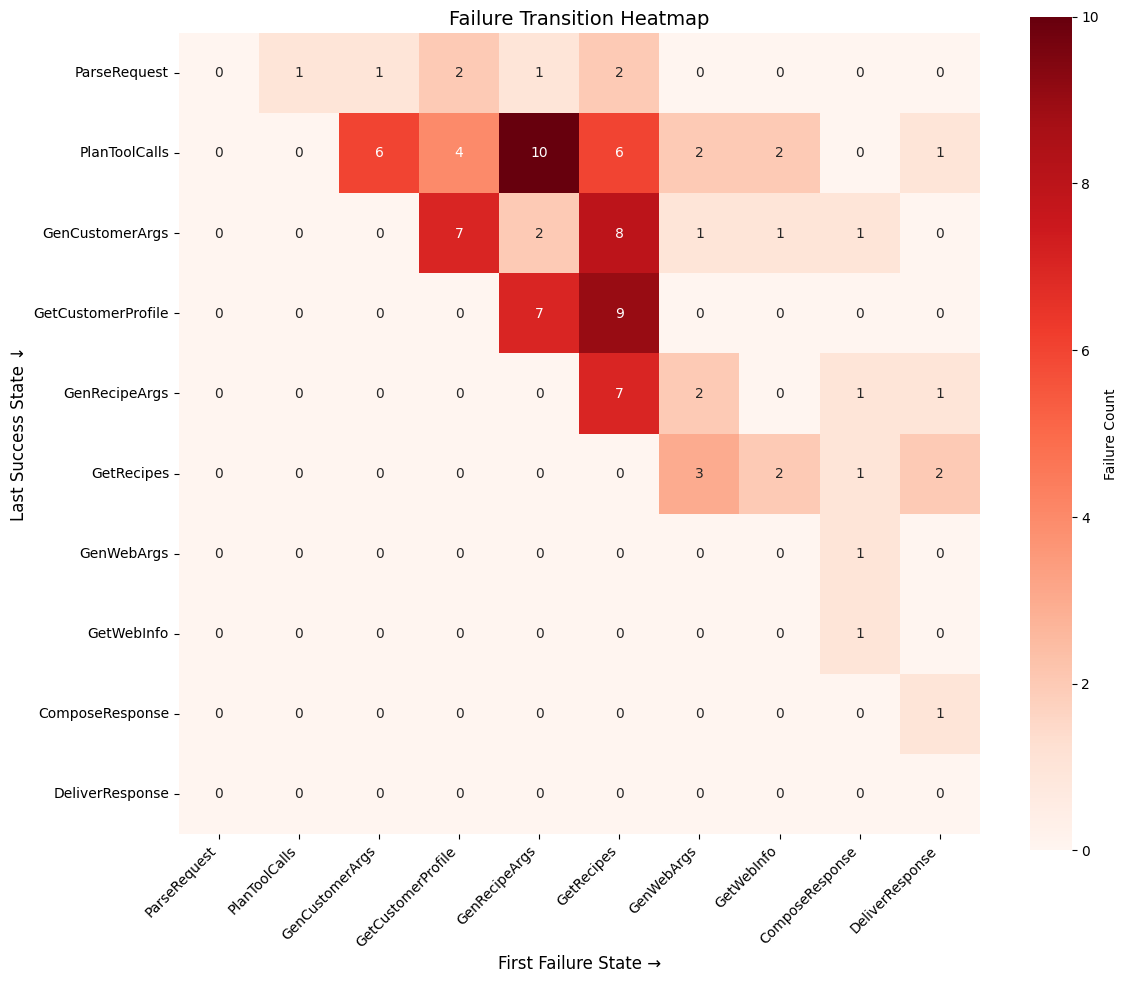

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=PIPELINE_STATES,
    yticklabels=PIPELINE_STATES,
    cbar_kws={'label': 'Failure Count'},
    square=True
)
plt.title('Failure Transition Heatmap', fontsize=14)
plt.xlabel('First Failure State →', fontsize=12)
plt.ylabel('Last Success State ↓', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Analyze the Patterns

Now we turn pictures into priorities. Which steps need the most attention?

> 💡 **Actionable insights**: If "GetRecipes" fails 32 times, that's where you start debugging. Maybe the recipe database has gaps, or search queries are malformed. The heatmap points you to *where*, then you investigate *why*.

In [9]:
# Which states fail most often?
print("States that fail most often (as first failure):")
failure_totals = matrix.sum(axis=0)  # Sum columns
for idx in np.argsort(failure_totals)[::-1]:
    if failure_totals[idx] > 0:
        print(f"  {PIPELINE_STATES[idx]}: {failure_totals[idx]} failures")

States that fail most often (as first failure):
  GetRecipes: 32 failures
  GenRecipeArgs: 20 failures
  GetCustomerProfile: 13 failures
  GenWebArgs: 8 failures
  GenCustomerArgs: 7 failures
  DeliverResponse: 5 failures
  ComposeResponse: 5 failures
  GetWebInfo: 5 failures
  PlanToolCalls: 1 failures


In [10]:
# Which states are the last to succeed before failure?
print("States that are last to succeed (before failure):")
success_totals = matrix.sum(axis=1)  # Sum rows
for idx in np.argsort(success_totals)[::-1]:
    if success_totals[idx] > 0:
        print(f"  {PIPELINE_STATES[idx]}: {success_totals[idx]} times")

States that are last to succeed (before failure):
  PlanToolCalls: 31 times
  GenCustomerArgs: 20 times
  GetCustomerProfile: 16 times
  GenRecipeArgs: 11 times
  GetRecipes: 8 times
  ParseRequest: 7 times
  ComposeResponse: 1 times
  GetWebInfo: 1 times
  GenWebArgs: 1 times


In [11]:
# Categorize: LLM steps (Gen*) vs Execution steps (Get*)
llm_states = ['ParseRequest', 'PlanToolCalls', 'GenCustomerArgs', 'GenRecipeArgs', 'GenWebArgs', 'ComposeResponse']
exec_states = ['GetCustomerProfile', 'GetRecipes', 'GetWebInfo', 'DeliverResponse']

llm_failures = sum(failure_states.get(s, 0) for s in llm_states)
exec_failures = sum(failure_states.get(s, 0) for s in exec_states)

print(f"LLM/Generation step failures: {llm_failures}")
print(f"Execution/Tool step failures: {exec_failures}")
print(f"\nThis suggests {'LLM steps' if llm_failures > exec_failures else 'execution steps'} are the bigger problem.")

LLM/Generation step failures: 41
Execution/Tool step failures: 55

This suggests execution steps are the bigger problem.


## 6. Write Your Analysis

Based on the heatmap, consider:

1. **Which states fail most often?**
   - Look at the column totals
   - These are your priority areas for improvement

2. **Do failures cluster around tool execution or argument generation?**
   - `Gen*` states = LLM generating arguments
   - `Get*` states = actually executing the tool
   - This tells you if the problem is the LLM or the infrastructure

3. **Any surprising low-frequency transitions?**
   - Some transitions that "should" happen might be missing
   - This could indicate states that are always skipped

Saved to results/failure_transition_heatmap.png


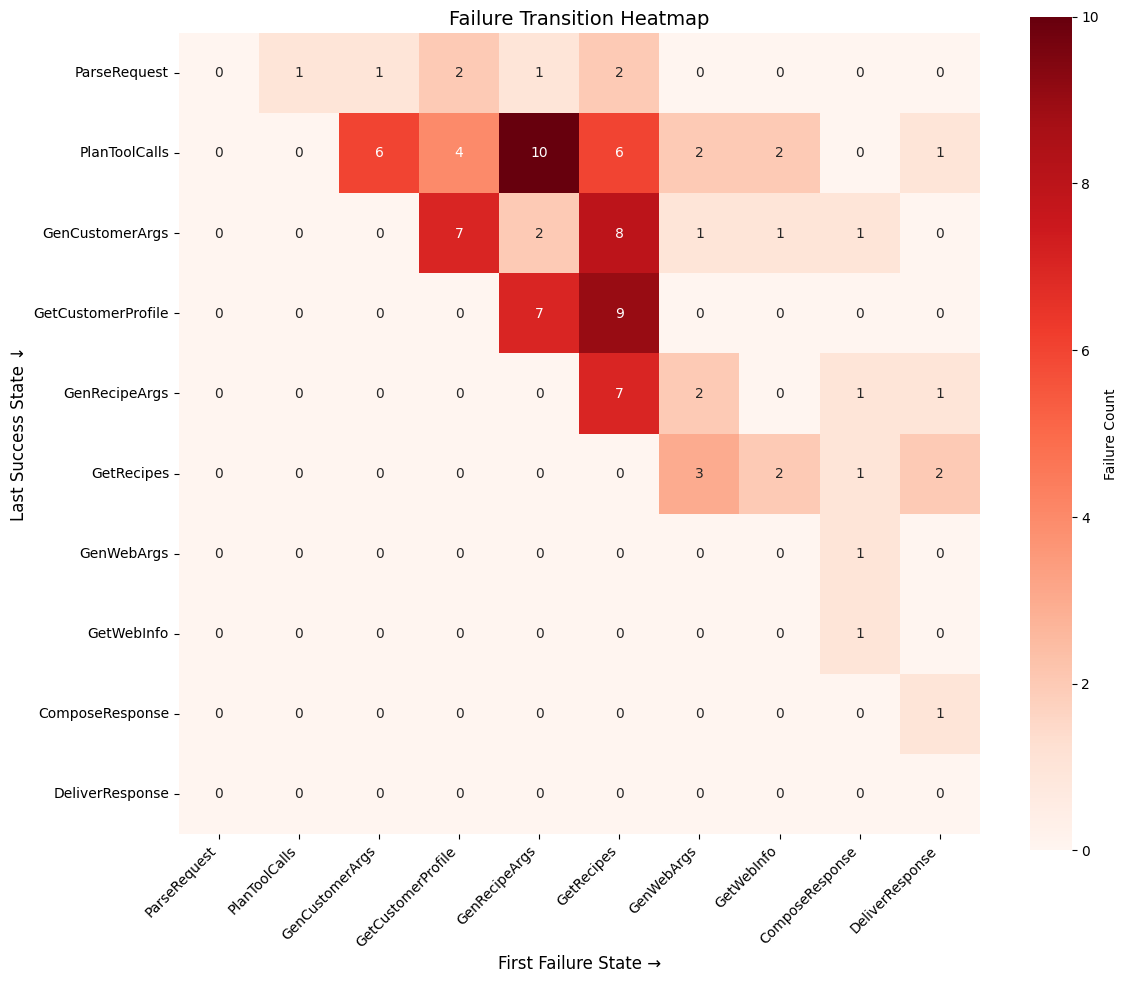

In [12]:
# Save the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=PIPELINE_STATES,
    yticklabels=PIPELINE_STATES,
    cbar_kws={'label': 'Failure Count'},
    square=True
)
plt.title('Failure Transition Heatmap', fontsize=14)
plt.xlabel('First Failure State →', fontsize=12)
plt.ylabel('Last Success State ↓', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/failure_transition_heatmap.png', dpi=300)
print("Saved to results/failure_transition_heatmap.png")

## Summary

**What we built:**
- Transition matrix from failure data
- Heatmap visualization of failure patterns

**Key insights from this data:**
- The most common failure points reveal system weaknesses
- Patterns in transitions can suggest root causes
- Categorizing by LLM vs execution steps helps prioritize fixes

**Your deliverables:**
- The heatmap PNG
- A short write-up of your analysis